In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
import pandas as pd
import ast
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'e'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

In [3]:
bad = []
for isub in range(exp.nsub):
    try:
        beh = exp.load_behavior(isub)
    except:
        bad.append(isub)

In [9]:
time_window = 25 
time_step = 25
trial_bin_size = 10
n_splits = 30
group_dict = OrderedDict([('SS1 0 Coh',[0]),('SS1 1 Coh',[1]), ('SS2 0 Coh', [2]), ('SS2 1 Coh', [3]), ('SS2 2 Coh',[4])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub, num_labels=5)

In [5]:
def format_coh(row): return ast.literal_eval(row.replace(', ',',').replace(' ',','))
def get_coherences(df):
    
    coherences = df['Coherences'].apply(format_coh)
    coh_1 = coherences.apply(lambda row: row[0]).values
    coh_2 = coherences.apply(lambda row: row[1]).values
    return coh_1, coh_2

In [6]:
def create_new_label(row):
    if row['SetSize']==1:
        return f'ss1_coh{row["coh1"]}'
    else:
        return f'ss2_coh{row["coh1"]+row["coh2"]}'

In [7]:
def prep_data(xdata,beh):
    # remove ss0 and attend color
    remove_ss0 = (beh.SetSize!=0).astype(bool)
    xdata, beh = xdata[remove_ss0], beh.query('SetSize!=0')
    remove_color = (beh.BlockFeature!=0).astype(bool)
    xdata, beh = xdata[remove_color], beh.query('BlockFeature!=0')

    # get coherences for memory items
    coh1, coh2 = get_coherences(beh)
    beh.loc[:,'coh1'], beh.loc[:,'coh2'] = coh1, coh2

    # get labels
    beh.loc[:,'labels'] = beh.apply(create_new_label,axis=1)
    label_remap = {'ss1_coh0':0,'ss1_coh1':1,'ss2_coh0':2,'ss2_coh1':3,'ss2_coh2':4}
    ydata = beh['labels'].map(label_remap)
    return xdata, ydata.values

In [ ]:
for isub in range(exp.nsub):
    print(isub)

    xdata,_ = exp.load_eeg(isub)
    beh = pd.DataFrame(exp.load_behavior(isub))
    
    xdata,ydata = prep_data(xdata,beh)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata, test_size=.3):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
interp_motion = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_motion') 
# interp_motion.save_results(timestamp=False)

In [27]:
interp_motion = eeg_decoder.Interpreter(clfr, subtitle='coh_attend_motion') 

No handles with labels found to put in legend.


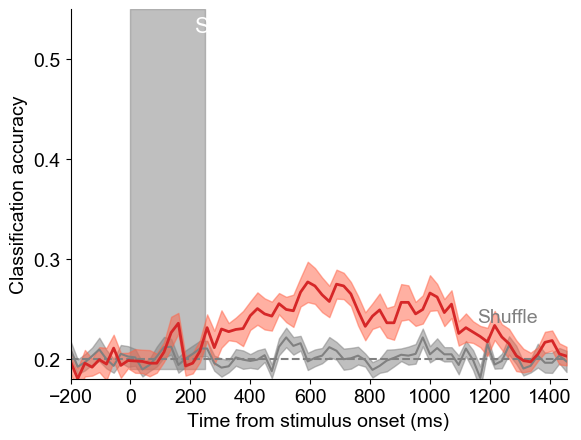

Mean delay accuracy: 0.23841394335511987
Mean delay S.D.: 0.02133265338458184


In [12]:
interp_motion.plot_acc()

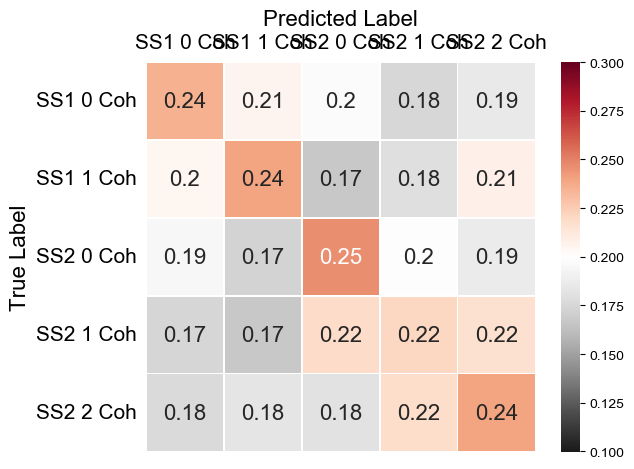

In [15]:
interp_motion.plot_confusion_matrix(lower=.1,upper=.3,chance=.2)

Saving output\figures\coh_attend_motionhyperplanecoh_hyperplane.pdf
Saving output\figures\coh_attend_motionhyperplanecoh_hyperplane.png


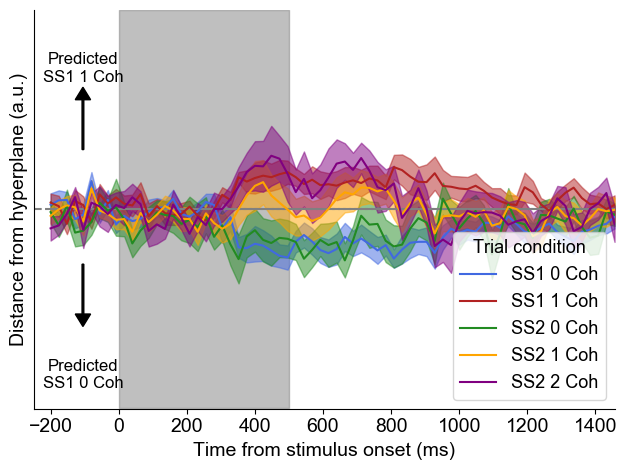

In [31]:
interp_motion.plot_hyperplane(
    subtitle='coh_hyperplane',
    stim_time=[0,500],
    label_text_ys=[-3,2.5],
    train_labels = ['SS1 0 Coh','SS1 1 Coh'],
    savefig=True
)